In [1]:
# importeren van alle functies en het lezen van het databestand.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.express as px
import cufflinks as cf
import numpy as np
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.cluster import KMeans
df=pd.read_excel("Complete-dataset-FINAL.xlsx")

In [2]:
# business/data understanding: hoe ziet de data er uit?
df
df.info();
df.describe().transpose();
df.columns;

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4684 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Method name          4684 non-null   object 
 1   N (no. labs)         4684 non-null   object 
 2   Mean                 4602 non-null   float64
 3   Bias                 4058 non-null   float64
 4   CV                   4584 non-null   float64
 5   Sample               4684 non-null   object 
 6   Reference Value      4656 non-null   float64
 7   Year                 4684 non-null   int64  
 8   Source (CAP/EurA1c)  4684 non-null   object 
 9   Type (Fresh/frozen)  4684 non-null   object 
 10  Manufacturer         4684 non-null   object 
 11  Total Error          4684 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 439.2+ KB


In [3]:
#data preparation: alleen de kolommen die van toepassing zijn, terug laten komen in de dataset.
df2 = df[["Mean","Bias","CV","Year","Manufacturer","Total Error"]];

In [4]:
df2

,Mean,Bias,CV,Year,Manufacturer,Total Error
0,6.14,-0.16,2.3,2011,Vitros,4.348
1,7.59,-0.01,2.5,2011,Vitros,4.890
2,9.42,0.22,3.0,2011,Vitros,6.100
3,5.42,-0.18,2.3,2012,Vitros,4.328
4,9.34,-0.06,2.6,2012,Vitros,5.036
...,...,...,...,...,...,...
4679,9.08,0.22,3.1,2021,Vitros,6.296
4680,6.86,0.02,2.6,2021,Vitros,5.116
4681,9.40,0.01,3.4,2021,Vitros,6.674
4682,6.14,0.01,2.5,2021,Vitros,4.910


In [20]:
df2 = df2.sort_values(["Manufacturer"])
df2

,Mean,Bias,CV,Year,Manufacturer,Total Error
290,5.28,-0.02,3.5,2013,Abbott,6.840
123,5.00,NaN,5.0,2007,Abbott,9.800
122,11.60,NaN,5.0,2006,Abbott,9.800
121,6.60,NaN,7.7,2006,Abbott,15.092
120,6.50,NaN,7.4,2006,Abbott,14.504
...,...,...,...,...,...,...
4678,10.15,0.03,3.2,2021,Vitros,6.302
4679,9.08,0.22,3.1,2021,Vitros,6.296
4609,6.10,NaN,3.8,2007,Vitros,7.448
4632,5.48,0.08,3.6,2011,Vitros,7.136


In [6]:
# data prep: Groeperen van manufacturer op jaar, en daarna de index setten op manufacturer
df3 = df2[df2["Manufacturer"]=='Abbott']

df4 = df2.groupby(["Manufacturer","Year"]).mean()
df4 = df4.reset_index()
df4 = df4.set_index('Manufacturer')
df4

,Year,Mean,Bias,CV,Total Error
Manufacturer,,,,,
Abbott,2006,8.155556,NaN,6.744444,13.219111
Abbott,2007,8.233333,NaN,4.500000,8.820000
Abbott,2008,8.400000,NaN,4.800000,9.408000
Abbott,2009,7.158333,0.183333,5.366667,10.610333
Abbott,2010,7.243333,0.026667,4.616667,9.075333
...,...,...,...,...,...
Vitros,2017,7.529333,0.074000,2.626667,5.222267
Vitros,2018,7.108000,-0.029333,2.573333,5.014400
Vitros,2019,7.080635,0.407647,3.064706,6.414471


In [7]:
# sns.pairplot(df4, hue='Manufacturer', kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}});

In [8]:
def plotPair(manufacturer):
    df3 = df2[df2["Manufacturer"]== manufacturer]
    sns.pairplot(df3, hue='Manufacturer', kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}});

In [9]:
interact(plotPair, manufacturer = df2['Manufacturer'].unique())

interactive(children=(Dropdown(description='manufacturer', options=('Abbott', 'Alere', 'Arkray', 'Axis-Shield'…

<function __main__.plotPair(manufacturer)>

In [10]:
df5 = df4.reset_index()

In [11]:
df5

,Manufacturer,Year,Mean,Bias,CV,Total Error
0,Abbott,2006,8.155556,NaN,6.744444,13.219111
1,Abbott,2007,8.233333,NaN,4.500000,8.820000
2,Abbott,2008,8.400000,NaN,4.800000,9.408000
3,Abbott,2009,7.158333,0.183333,5.366667,10.610333
4,Abbott,2010,7.243333,0.026667,4.616667,9.075333
...,...,...,...,...,...,...
208,Vitros,2017,7.529333,0.074000,2.626667,5.222267
209,Vitros,2018,7.108000,-0.029333,2.573333,5.014400
210,Vitros,2019,7.080635,0.407647,3.064706,6.414471
211,Vitros,2020,7.110667,-0.110667,2.693333,5.168267


In [12]:
# tel het aantal jaar dat een merk actief is. Mocht deze maar in 1 jaar voorkomen, haal die dan uit de dataset.
value_counts = df5["Manufacturer"].value_counts()
to_remove = value_counts[value_counts <= 1].index
ja = df5[~df5.Manufacturer.isin(to_remove)]
df5 = ja

In [13]:
lekkertellen = ja["Manufacturer"].value_counts()
lekkertellen

Abbott                       16
Beckman Coulter              16
Tosoh                        16
Roche Diagnostics            16
Bio-Rad                      16
Vitros                       16
Siemens                      14
Trinity Biotech              13
Sebia                         8
Roche Diagnostics/Hitachi     7
Axis-Shield                   7
Arkray                        6
Alere                         6
Olympus                       5
Not specified                 5
Menarini                      5
Metrika                       5
Primus                        4
Synchron                      4
Bayer                         3
Medinor                       3
HemoCue                       3
Bayer/Metrika                 3
JEOL                          2
EKF Diagnostics               2
Sysmex                        2
Thermo Scientific             2
Dade Behring                  2
BioMajesty                    2
Name: Manufacturer, dtype: int64

In [14]:
# Realiseren: laat de lijngrafieken zien die bij een specifieke manufacturer horen.
def lijngrafiek(manufacturer):
    df6 = df5[df5["Manufacturer"]== manufacturer]
    sns.relplot(data=df5, x="Year", y="CV", hue=df6.Manufacturer, kind="line")
    sns.relplot(data=df5, x="Year", y="Bias", hue=df6.Manufacturer, kind="line")
    sns.relplot(data=df5, x="Year", y="Total Error", hue=df6.Manufacturer, kind="line")

In [15]:
interact(lijngrafiek, manufacturer = df5['Manufacturer'].unique())

interactive(children=(Dropdown(description='manufacturer', options=('Abbott', 'Alere', 'Arkray', 'Axis-Shield'…

<function __main__.lijngrafiek(manufacturer)>

In [21]:
# regressievergelijking waarop kan worden voorspeld.
def regressie(manufacturer):
    df6 = df5[df5["Manufacturer"]== manufacturer]
    sns.regplot(data=df6, x="Year", y="CV")
    sns.regplot(data=df6, x="Year", y="Bias")
    sns.regplot(data=df6, x="Year", y="Total Error")
#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [22]:
interact(regressie, manufacturer = df5['Manufacturer'].unique())

interactive(children=(Dropdown(description='manufacturer', options=('Abbott', 'Alere', 'Arkray', 'Axis-Shield'…

<function __main__.regressie(manufacturer)>

In [26]:
df5

,Manufacturer,Year,Mean,Bias,CV,Total Error
0,Abbott,2006,8.155556,NaN,6.744444,13.219111
1,Abbott,2007,8.233333,NaN,4.500000,8.820000
2,Abbott,2008,8.400000,NaN,4.800000,9.408000
3,Abbott,2009,7.158333,0.183333,5.366667,10.610333
4,Abbott,2010,7.243333,0.026667,4.616667,9.075333
...,...,...,...,...,...,...
208,Vitros,2017,7.529333,0.074000,2.626667,5.222267
209,Vitros,2018,7.108000,-0.029333,2.573333,5.014400
210,Vitros,2019,7.080635,0.407647,3.064706,6.414471
211,Vitros,2020,7.110667,-0.110667,2.693333,5.168267


In [36]:
import statsmodels.api as sm
def regressie01(manufacturer):
    tempdf = df2[df2["Manufacturer"]== manufacturer]
    X = tempdf["Year"]
    y = tempdf["CV"]

    # Fit and make the predictions by the model
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # Print out the statistics
#     return model.summary()
    return tempdf

In [37]:
regressie("Abbott")

,Mean,Bias,CV,Year,Manufacturer,Total Error
290,5.28,-0.02,3.5,2013,Abbott,6.840
123,5.00,NaN,5.0,2007,Abbott,9.800
122,11.60,NaN,5.0,2006,Abbott,9.800
121,6.60,NaN,7.7,2006,Abbott,15.092
120,6.50,NaN,7.4,2006,Abbott,14.504
...,...,...,...,...,...,...
353,9.36,-0.17,5.7,2017,Abbott,11.002
354,5.42,0.08,2.7,2017,Abbott,5.372
355,NaN,NaN,NaN,2017,Abbott,0.000
356,NaN,NaN,NaN,2017,Abbott,0.000


In [40]:
import statsmodels.api as sm
def regressie02(manufacturer):
    tempdf = df2[df2["Manufacturer"]== manufacturer].dropna()
    X = tempdf["Year"]
    y = tempdf["CV"]

    # Fit and make the predictions by the model
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # Print out the statistics
    return model.summary()
#     return tempdf

In [41]:
regressie02("Abbott")

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     CV   R-squared (uncentered):                   0.683
Model:                            OLS   Adj. R-squared (uncentered):              0.682
Method:                 Least Squares   F-statistic:                              596.3
Date:                Wed, 25 May 2022   Prob (F-statistic):                    4.93e-71
Time:                        10:49:56   Log-Likelihood:                         -605.57
No. Observations:                 278   AIC:                                      1213.
Df Residuals:                     277   BIC:                                      1217.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0016   6.37e-05     24.420      0.000       0.001       0.002
==============================================================================
Omnibus:                       41.030   Durbin-Watson:                   1.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.151
Skew:                           1.076   Prob(JB):                     1.06e-12
Kurtosis:                       3.360   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
tempdf = df2[df2["Manufacturer"]== "Abbott"].dropna()
X = tempdf["Year"]
y = tempdf["CV"]

# Fit and make the predictions by the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
preddf = pd.DataFrame(predictions, columns=['CV'])
preddf['Year'] = "2022"
preddf = preddf.groupby('Year').mean().reset_index()
# Print out the statistics
# model.summary()

In [72]:
test = pd.concat([tempdf,preddf])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 290 to 0
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mean          278 non-null    float64
 1   Bias          278 non-null    float64
 2   CV            279 non-null    float64
 3   Year          279 non-null    object 
 4   Manufacturer  278 non-null    object 
 5   Total Error   278 non-null    float64
dtypes: float64(4), object(2)
memory usage: 15.3+ KB


In [75]:
test['Year'] = test['Year'].astype(str).astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 290 to 0
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mean          278 non-null    float64
 1   Bias          278 non-null    float64
 2   CV            279 non-null    float64
 3   Year          279 non-null    int32  
 4   Manufacturer  278 non-null    object 
 5   Total Error   278 non-null    float64
dtypes: float64(4), int32(1), object(1)
memory usage: 14.2+ KB


<AxesSubplot:xlabel='Year', ylabel='CV'>

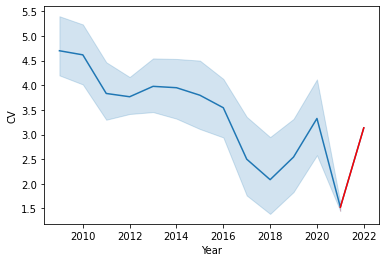

In [40]:
sns.lineplot(x = 'Year', y = 'CV', data = test)
sns.lineplot(x = 'Year', y = 'CV', data = test[(test['Year'] >= 2021) & (test['Year'] <= 2022)], color= 'red')

In [64]:
hoi = test.loc[test['Year'] == max(test['Year']) - 1].groupby('Year').mean()
hoi2 = test.loc[test['Year'] == max(test['Year'])]
hoi2

,Mean,Bias,CV,Year,Manufacturer,Total Error
0,NaN,NaN,3.135438,2022,NaN,NaN


In [46]:
ja = max(tempdf['Year']) + 1
ja

2022

In [67]:
# Groupby Method name
manufacturer = df2.dropna().groupby('Manufacturer')
# order manufacturer by size
manufacturerSizes = manufacturer.size().sort_values(ascending=False)
# Only show top more then 100 size
manufacturerSizes = manufacturerSizes[manufacturerSizes > 100]
# Make a new dataframe with the top manufacturers from df
df_manufacturer = df2[df2['Manufacturer'].isin(manufacturerSizes.index)]
# df_manufacturer = df_manufacturer[df_manufacturer['Source (CAP/EurA1c)'] == 'CAP']
df_manufacturer

,Mean,Bias,CV,Year,Manufacturer,Total Error
290,5.28,-0.02,3.5,2013,Abbott,6.840
262,8.70,0.10,1.1,2019,Abbott,2.256
261,6.39,-0.02,1.3,2019,Abbott,2.528
260,7.53,-0.09,1.0,2018,Abbott,1.870
259,8.30,-0.05,1.0,2018,Abbott,1.910
...,...,...,...,...,...,...
56,5.42,-0.03,2.1,2017,Vitros,4.086
57,7.16,0.01,3.0,2018,Vitros,5.890
58,5.25,0.06,2.4,2018,Vitros,4.764
60,9.71,-0.08,3.1,2018,Vitros,5.996


In [91]:
def maakModel(manufacturer):
    tempdf = df_manufacturer[df_manufacturer["Manufacturer"]== manufacturer].dropna()
    X = tempdf["Year"]
    y = tempdf["CV"]

    # Fit and make the predictions by the model
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    preddf = pd.DataFrame(predictions, columns=['CV'])
    preddf['Year'] = "2022"
    preddf = preddf.groupby('Year').mean().reset_index()
    test = pd.concat([tempdf,preddf])
    test['Year'] = test['Year'].astype(str).astype(int)
    test = test.reset_index(drop=True)
    sns.lineplot(x = 'Year', y = 'CV', data = test)
    sns.lineplot(x = 'Year', y = 'CV', data = test[(test['Year'] >= 2021) & (test['Year'] <= 2022)], color= 'red')
    # Print out the statistics
    return model.summary()

In [92]:
interact(maakModel, manufacturer=df_manufacturer['Manufacturer'].unique())

interactive(children=(Dropdown(description='manufacturer', options=('Abbott', 'Alere', 'Beckman Coulter', 'Bio…

<function __main__.maakModel(manufacturer)>

# Evaluation

Bij alle manufacturers daalt de cv waarde heel veel. Hierop is de predictie niet voorbereid waardoor hij opeens voor het jaar 2022 heel hoog uitvalt.